# Settings

Import the libraries

In [ ]:
import tensorflow as tf
import numpy as np
import os
import random
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator

tfk = tf.keras
tfkl = tf.keras.layers

In [2]:
# Random seed for reproducibility
seed = 25

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

Constants

In [3]:
# Labels
LABELS = ['Species1','Species2','Species3','Species4','Species5','Species6','Species7','Species8']

In [4]:
# Model hyperparameters
INPUT_SHAPE = (96, 96, 3)
IMAGE_SIZE = (INPUT_SHAPE[0], INPUT_SHAPE[1])

EPOCHS = 100
BATCH_SIZE = 64

NUM_CLASSES = len(LABELS)

# Data loading

In [5]:
# Paths
DATA_DIR = 'training_data_final'

PATH = {}
PATH['training'] = os.path.join(DATA_DIR, 'training')
PATH['validation'] = os.path.join(DATA_DIR, 'validation')
PATH['testing'] = os.path.join(DATA_DIR, 'testing')

In [6]:
train_data_gen = ImageDataGenerator(
    rotation_range=30,
    height_shift_range=40,
    width_shift_range=40,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.7,1.3],
    fill_mode='reflect'
) 

train_gen = train_data_gen.flow_from_directory(
    directory=PATH['training'],
    target_size=IMAGE_SIZE,
    color_mode='rgb',
    classes=None,
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=seed
)

Found 2299 images belonging to 8 classes.


In [7]:
valid_gen = ImageDataGenerator().flow_from_directory(
    directory=PATH['validation'],
    target_size=IMAGE_SIZE,
    color_mode='rgb',
    classes=None,
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=seed
)

Found 530 images belonging to 8 classes.


In [8]:
test_gen = ImageDataGenerator().flow_from_directory(
    directory=PATH['testing'],
    target_size=IMAGE_SIZE,
    color_mode='rgb',
    classes=None,
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False,
    seed=seed
)

Found 713 images belonging to 8 classes.


# Training the model

Set the best performing tuned class weights found during the fine-tuning.

In [9]:
cw = {}

for i in range(0,8):
    cw[i] = 1.0

cw[0] = 3.0
cw[3] = 2.0
cw[5] = 1.5
cw[7] = 2.0

print(cw)

{0: 3.0, 1: 1.0, 2: 1.0, 3: 2.0, 4: 1.0, 5: 1.5, 6: 1.0, 7: 2.0}


In [10]:
def create(layers, d=0.3):
    pretrained_model= tf.keras.applications.ConvNeXtLarge(include_top=False,input_shape=INPUT_SHAPE,weights='imagenet')

    pretrained_model.trainable = False

    inputs = tfk.Input(shape=INPUT_SHAPE)
    conv = pretrained_model(inputs)
    classifier_layer = tfkl.GlobalAveragePooling2D()(conv)
    classifier_layer = tfkl.Dropout(d, seed=seed)(classifier_layer)

    for layer in layers:
        classifier_layer = tfkl.Dense(units=layer, kernel_initializer = tfk.initializers.GlorotUniform(seed))(classifier_layer)
        classifier_layer = tfkl.Dropout(d, seed=seed)(classifier_layer)
        classifier_layer = tfkl.BatchNormalization()(classifier_layer)
        classifier_layer = tf.keras.activations.relu(classifier_layer)

    output_layer = tfkl.Dense(
        units=NUM_CLASSES,
        activation='softmax',
        kernel_initializer = tfk.initializers.GlorotUniform(seed))(classifier_layer)

    model = tfk.Model(inputs=inputs, outputs=output_layer, name='model')
    return model

def train(model,layers_to_freeze,learning_r,min_l,clssw,fac=0.5,pat=4):
    MODEL_NAME = 'convnext_large'
    model.get_layer(MODEL_NAME).trainable = True

    for i, layer in enumerate(model.get_layer(MODEL_NAME).layers[:layers_to_freeze]):
        layer.trainable=False

    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(learning_rate=learning_r), metrics=['categorical_accuracy'])

    with tf.device("/GPU:0"): # Force GPU use
        history = model.fit(
            x = train_gen,
            batch_size = BATCH_SIZE,
            epochs = EPOCHS,
            validation_data = valid_gen,
            class_weight=clssw,
            #verbose=0,
            callbacks=[tfk.callbacks.EarlyStopping(monitor='val_categorical_accuracy', mode='max', patience=10, restore_best_weights=True),tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=fac, patience=pat, min_lr=min_l, min_delta=0.00001, restore_best_weights=True)]
        ).history
    
    return (model, history)

In [11]:
with_c = create(['1024'], d=0.3)
t_c = train(with_c, 295, 1e-3, 0.0, cw, fac=0.5, pat=4)   # Transfer learning
t_cnn = train(t_c[0], 90, 1e-4, 5e-5, cw, fac=0.6, pat=4) # Fine-tuning

Epoch 1/100
36/36 [==============================] - 33s 540ms/step - loss: 1.9271 - categorical_accuracy: 0.5237 - val_loss: 0.8481 - val_categorical_accuracy: 0.6925 - lr: 0.0010
Epoch 2/100
36/36 [==============================] - 13s 362ms/step - loss: 1.3550 - categorical_accuracy: 0.6642 - val_loss: 0.8153 - val_categorical_accuracy: 0.7000 - lr: 0.0010
Epoch 3/100
36/36 [==============================] - 14s 374ms/step - loss: 1.2597 - categorical_accuracy: 0.6951 - val_loss: 0.6871 - val_categorical_accuracy: 0.7642 - lr: 0.0010
Epoch 4/100
36/36 [==============================] - 14s 374ms/step - loss: 1.1509 - categorical_accuracy: 0.7221 - val_loss: 0.5950 - val_categorical_accuracy: 0.8000 - lr: 0.0010
Epoch 5/100
36/36 [==============================] - 13s 365ms/step - loss: 1.1319 - categorical_accuracy: 0.7299 - val_loss: 0.5467 - val_categorical_accuracy: 0.8245 - lr: 0.0010
Epoch 6/100
36/36 [==============================] - 13s 365ms/step - loss: 1.0191 - categorica

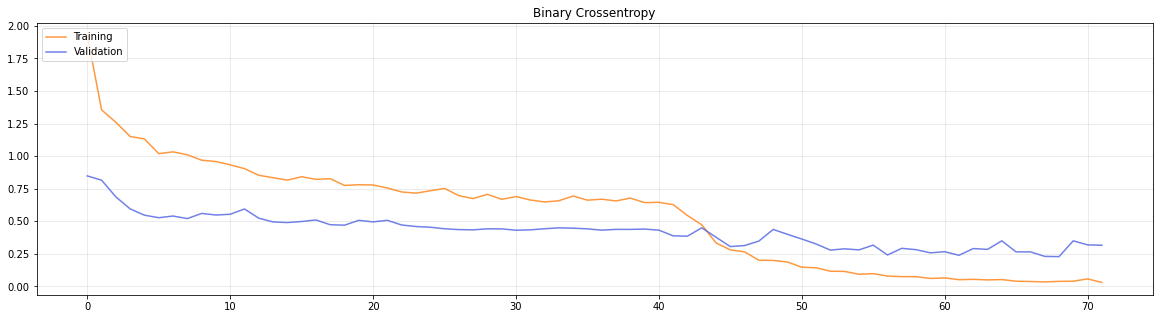

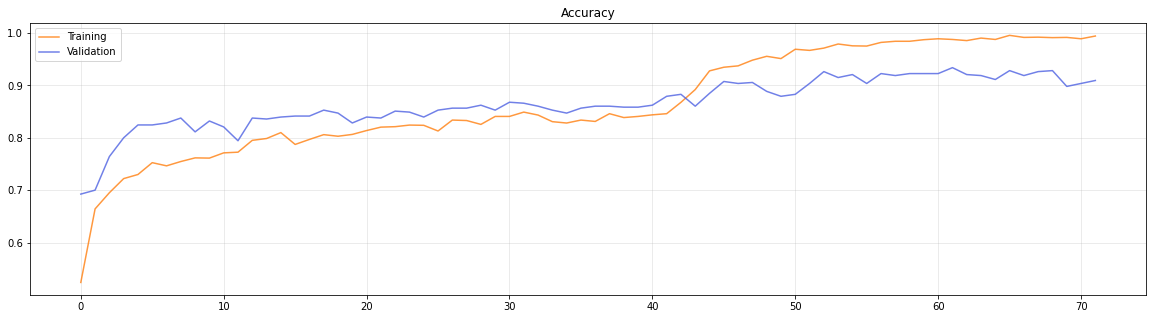

In [12]:
plt.figure(figsize=(20,5))
plt.plot(t_c[1]['loss']+t_cnn[1]['loss'], label='Training', alpha=.8, color='#ff7f0e')
plt.plot(t_c[1]['val_loss']+t_cnn[1]['val_loss'], label='Validation', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Binary Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(20,5))
plt.plot(t_c[1]['categorical_accuracy']+t_cnn[1]['categorical_accuracy'], label='Training', alpha=.8, color='#ff7f0e')
plt.plot(t_c[1]['val_categorical_accuracy']+t_cnn[1]['val_categorical_accuracy'], label='Validation', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

In [13]:
t_cnn[0].summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 convnext_large (Functional)  (None, 3, 3, 1536)       196230336 
                                                                 
 global_average_pooling2d (G  (None, 1536)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1536)              0         
                                                                 
 dense (Dense)               (None, 1024)              1573888   
                                                                 
 dropout_1 (Dropout)         (None, 1024)              0         
                                                             

# Test

In [14]:
test_steps_per_epoch = np.math.ceil(test_gen.samples / test_gen.batch_size)
predictions = t_cnn[0].predict(test_gen, steps=test_steps_per_epoch)
predicted_classes = np.argmax(predictions, axis=-1)
true_classes = test_gen.classes
class_labels = list(test_gen.class_indices.keys())

12/12 [==============================] - 6s 322ms/step


Accuracy: 0.9467
Precision: 0.9478
Recall: 0.9317
F1: 0.9376


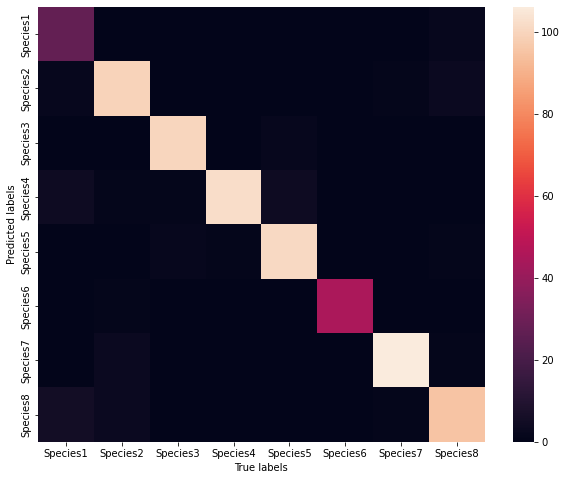

In [15]:
cm = confusion_matrix(true_classes, predicted_classes)

accuracy = accuracy_score(true_classes, predicted_classes)
precision = precision_score(true_classes, predicted_classes, average='macro')
recall = recall_score(true_classes, predicted_classes, average='macro')
f1 = f1_score(true_classes, predicted_classes, average='macro')
print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))

plt.figure(figsize=(10,8))
sns.heatmap(cm.T, xticklabels=list(class_labels), yticklabels=class_labels)
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

In [16]:
# t_cnn[0].save("CNN")